In [1]:
import torch
import torch.nn as nn
import hiddenlayer as hl
from dataset import SimulationData
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import tqdm
from model import MainNet

C:\Users\Pietro\anaconda3\envs\rans\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset0 = SimulationData(stencilNum=1000,samplePerStencil=50,fileName="aw=1.3_internal.csv", override=False)
dataset1 = SimulationData(stencilNum=1000,samplePerStencil=50,fileName="aw=1.7_internal.csv", override=False)
dataset2 = SimulationData(stencilNum=1000,samplePerStencil=50,fileName="aw=2.0_internal.csv", override=False)


In [3]:
input_size1 = dataset2.x.shape[2]
hidden_size1_1 = 32
hidden_size1_2 = 64
output_size1 = 256

input_size2 = 256*50
hidden_size2_1 = 64
hidden_size2_2 = 32
output_size2 = 3

model_50 = MainNet(input_size1, hidden_size1_1, hidden_size1_2, output_size1, input_size2,hidden_size2_1, hidden_size2_2, output_size2)
model_100 = MainNet(input_size1, hidden_size1_1, hidden_size1_2, output_size1, input_size2,hidden_size2_1, hidden_size2_2, output_size2)
model_200 = MainNet(input_size1, hidden_size1_1, hidden_size1_2, output_size1, input_size2,hidden_size2_1, hidden_size2_2, output_size2)
model_300 = MainNet(input_size1, hidden_size1_1, hidden_size1_2, output_size1, input_size2,hidden_size2_1, hidden_size2_2, output_size2)

In [4]:
model_50.load_state_dict(torch.load("./models/net.pth"))
model_100.load_state_dict(torch.load("./models/net_C=1000_S=50_E=100.pth"))
model_200.load_state_dict(torch.load("./models/net_C=1000_S=50_E=200.pth"))
model_300.load_state_dict(torch.load("./models/net_C=1000_S=50_E=300.pth"))

<All keys matched successfully>

In [5]:
def get_data(dataset, model):
    x = []
    y = []
    z = []
    true_z = []
    for i in range(len(dataset)):
        features, labels = dataset[i]
        centerpoint = dataset.centers[i]
        true_z.append(labels[2].item())
        x.append(centerpoint[0].item())
        y.append(centerpoint[1].item())
        output = model(features.float())[2].item()
        z.append(output)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    true_z = np.array(true_z)
    return x, y, z, true_z


In [22]:
def contour(x, y, z, true_z, save=True, path='./images/countour.png'):
    xi, yi = np.linspace(x.min(),x.max(), 3000), np.linspace(y.min(), y.max(), 3000)
    xi, yi = np.meshgrid(xi, yi)
    zi_predicted = scipy.interpolate.griddata((x, y), z, (xi, yi), method='linear')
    zi_true = scipy.interpolate.griddata((x, y), true_z , (xi, yi), method='linear')

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

    ax1.set(xlim=[-0.3, 13.2], ylim=[-0.3, 3.3], aspect=1)
    ax2.set(xlim=[-0.3, 13.2], ylim=[-0.3, 3.3], aspect=1)

    ax1_plot = ax1.contourf(xi, yi, zi_true, vmin=-0.15, vmax=1.05)
    ax2_plot = ax2.contourf(xi, yi, zi_predicted, vmin=-0.15, vmax=1.05)
    plt.colorbar(ax1_plot,ax=[ax2, ax1], orientation='horizontal', shrink=0.7, location="top", label="ν", aspect=50, ticks=[-0.15, 0.15, 0.45, 0.75, 1.05])
    if(save):
        plt.savefig(path, dpi=1500)
    plt.show()

In [13]:
x, y, z, true_z = get_data(dataset1, model_300)

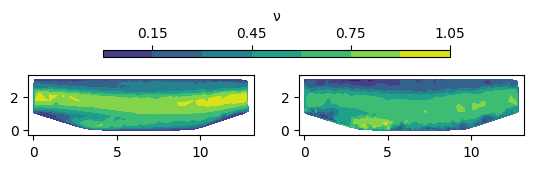

In [23]:
#x, y, z, true_z = get_data(dataset2, model_300)
contour(x,y,z, true_z,  path='./images/contours/contour_2.0_300.png')

In [ ]:
plt.scatter(dataset3.x[:,0], dataset3.x[:,1])

In [ ]:
plt.xlim(-0.3, 10.3)
plt.ylim(-0.3, 3.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.contourf(xi, yi, zi, levels=10)
plt.savefig("./images/contour_6_true.png", dpi=1500)